In [ ]:
# Environement vriable from crisp_common.ipnb
# "tornado==6.4.1" \
# "pandas>=2.2.2,<3.0.0" \
# "matplotlib==3.9.1" \
# "scikit-learn>=1.5.1,<2.0.0" \
# "seaborn>=0.13.2,<0.14.0" \
# "plotly>=5.23.0,<6.0.0" \
# "openai>=1.44.1" \
# "langchain-openai>=0.2.1" \
# "folium>=0.17.0" \
# "ipywidgets>=7,<8" \
# "prophet==1.1.6" \
# "jax==0.5.3" \
# "numpyro==0.18.0" \
# "arviz==0.21.0"

This notebook demonstrates how to perform on-shelf availability analysis on sales data to identify patterns and trends over time. On-shelf availability is a measure of how well a retailer is able to keep products in stock and available for purchase. By analyzing sales data, we can identify products that are frequently out of stock and take steps to improve availability. This notebook leverages store clustering to identify patterns in sales data and detect anomalies.

## Set the required environment variables

In [1]:
import os

os.environ["ACCOUNT_ID"] = "999999"
# os.environ["CONNECTOR_ID"] = "7240"
retailer = "target"

### Run Crisp common notebook

This notebook uses the [crisp_common.ipynb](./crisp_common.ipynb) notebook to load the common functions and variables. The `crisp_common.ipynb` notebook contains the common functions and variables that are used across the Crisp notebooks.

In [3]:
dim_product = "harmonized_retailer_dim_product"
dim_store = "harmonized_retailer_dim_store"
fact_sales = "harmonized_retailer_fact_sales"
fact_inventory = "harmonized_retailer_fact_inventory_store"

In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display
from snowflake.snowpark.context import get_active_session
session = get_active_session()

### Get anchor date

For testing purposes, we need to set a specific anchor date to ensure we have consistent data, regardless of the test environment’s data availability. In a production environment, where live data is available, this step is not required.


In [ ]:
# assumes your Notebook provides a Snowpark Session named `session`
session.use_database("GOCRISP")
session.use_schema("SCHEMA_81879_8305")

# (optional) verify as a Snowpark DataFrame you can reuse downstream
ctx_df = session.sql("""
  SELECT CURRENT_DATABASE() AS database,
         CURRENT_SCHEMA()   AS schema
""")
ctx_df.show()          # or: ctx_df.collect() / ctx_df.to_pandas()




In [ ]:
from snowflake.snowpark.functions import col, lit, max as s_max, min as s_min
# If your DATE_KEY might be timestamp/number → we’ll cast to DATE explicitly

# parameter
retailer = "target"

# latest date in sales for the retailer
sales_latest = (
    session.table("HARMONIZED_RETAILER_FACT_SALES")
           .filter(col("RETAILER") == lit(retailer))
           .select(s_max(col("DATE_KEY")).cast("date").alias("ANCHOR_DATE"))
)

# latest date in inventory for the retailer
inv_latest = (
    session.table("HARMONIZED_RETAILER_FACT_INVENTORY_STORE")
           .filter(col("RETAILER") == lit(retailer))
           .select(s_max(col("DATE_KEY")).cast("date").alias("ANCHOR_DATE"))
)

# today's date
today_df = session.sql("SELECT CURRENT_DATE() AS ANCHOR_DATE")

# union and take the minimum → anchor date
anchor_df = (
    sales_latest.union_all(inv_latest).union_all(today_df)
                .select(s_min(col("ANCHOR_DATE")).alias("ANCHOR_DATE"))
)

# as a Snowpark DataFrame (show/joins)…
anchor_df.show()

# as a Python date scalar (handy for filters in later Snowpark code)
anchor_date = anchor_df.collect()[0]["ANCHOR_DATE"]



In [ ]:
from datetime import timedelta

# anchor_df comes from previous cell; grab the scalar date
anchor_date = anchor_df.collect()[0]["ANCHOR_DATE"]   # note UPPERCASE key

# 90-day window
start_date = anchor_date - timedelta(days=335)
end_date   = anchor_date - timedelta(days=245)

# For display
start_date_str = start_date.strftime("%Y-%m-%d")
end_date_str   = end_date.strftime("%Y-%m-%d")
print(f"Using data from {start_date_str} to {end_date_str}")

# If you truly need SQL literal text (for raw SQL strings), use:
start_date_sql = f"DATE '{start_date_str}'"
end_date_sql   = f"DATE '{end_date_str}'"


## Load data

We will limit the number of stores to just those from New York state to reduce the data size, as this process is computationally intensive. You can remove this filter if you have enough resources to handle the full dataset.

In [7]:
from snowflake.snowpark.functions import col, lit, sum as s_sum

# params: session, retailer (str), start_date/end_date (date)

# 1) Filter stores, but RENAME the key so it won't collide
limited_stores = (
    session.table("HARMONIZED_RETAILER_DIM_STORE")
           .filter(col("STORE_STATE").isin("NY"))
           .select(col("STORE_ID").alias("LS_STORE_ID"))
)

# 2) SALES aggregate (keep keys from the FACT table)
fs = session.table("HARMONIZED_RETAILER_FACT_SALES")
fact_sales = (
    fs.join(limited_stores, fs["STORE_ID"] == limited_stores["LS_STORE_ID"])
      .filter(fs["RETAILER"] == lit(retailer))
      .filter(fs["DATE_KEY"].cast("date") >= lit(start_date))
      .filter(fs["DATE_KEY"].cast("date") <= lit(end_date))
      .group_by(fs["DATE_KEY"], fs["STORE_ID"], fs["PRODUCT_ID"])
      .agg(s_sum(fs["SALES_QUANTITY"]).alias("SALES_QUANTITY"))
      # explicitly project canonical names to be 100% sure
      .select("DATE_KEY", "STORE_ID", "PRODUCT_ID", "SALES_QUANTITY")
)

# 3) INVENTORY aggregate (same pattern)
fi = session.table("HARMONIZED_RETAILER_FACT_INVENTORY_STORE")
fact_inventory = (
    fi.join(limited_stores, fi["STORE_ID"] == limited_stores["LS_STORE_ID"])
      .filter(fi["RETAILER"] == lit(retailer))
      .filter(fi["DATE_KEY"].cast("date") >= lit(start_date))
      .filter(fi["DATE_KEY"].cast("date") <= lit(end_date))
      .group_by(fi["DATE_KEY"], fi["STORE_ID"], fi["PRODUCT_ID"])
      .agg(s_sum(fi["ON_HAND_QUANTITY"]).alias("ON_HAND_QUANTITY"))
      .select("DATE_KEY", "STORE_ID", "PRODUCT_ID", "ON_HAND_QUANTITY")
)

# 4) FULL OUTER JOIN with USING columns (merges keys; no ambiguity)
df = (
    fact_sales.join(fact_inventory, ["DATE_KEY", "PRODUCT_ID", "STORE_ID"], "full")
              .select("DATE_KEY", "PRODUCT_ID", "STORE_ID", "SALES_QUANTITY", "ON_HAND_QUANTITY")
)

# Optional sanity check
print(fact_sales.columns)
print(fact_inventory.columns)
df.show()


In [8]:
from snowflake.snowpark.functions import col, coalesce, lit

# Use exact column names (Snowflake uppercases by default)
df = (
    df.with_column("SALES_QUANTITY",   coalesce(col("SALES_QUANTITY"),   lit(0)))
      .with_column("ON_HAND_QUANTITY", coalesce(col("ON_HAND_QUANTITY"), lit(0)))
)
df


,date_key,product_id,store_id,sales_quantity,on_hand_quantity
0,2024-10-05,101,98979065024344198,0,0
1,2024-10-07,101,385376782331704852,0,0
2,2024-10-11,101,686677604694809978,0,0
3,2024-10-13,101,870053854117237080,0,0
4,2024-10-15,101,11032598542241361,0,0
...,...,...,...,...,...
531435,2024-10-10,180,288226339723528194,3,6
531436,2024-10-19,180,216725622896583296,3,19
531437,2024-11-02,180,464331424209448676,3,3
531438,2024-12-25,180,972883243019783470,3,7


## Load store clusters

We will load the store clusters generated from the [store clustering notebook](https://github.com/gocrisp/blueprints/blob/main/notebooks/crisp_store_clustering.ipynb). If this notebook is not available, you can mark all stores as a single cluster.

In [9]:
# import os
# if os.path.exists("store_clusters.csv"):
#     dim_store_clusters = pd.read_csv("store_clusters.csv")
#     dim_store_clusters.value_counts("Cluster")
# else:
#     dim_store_clusters = pd.DataFrame(
#         {"store_id": df["store_id"].unique(), "Cluster": 0}
#     )
# dim_store_clusters.value_counts("Cluster")
dim_store_clusters = (
    df.select("STORE_ID").distinct()
      .with_column("CLUSTER", lit(0))
)
dim_store_clusters


Cluster
2    52
0    47
1    40
3    38
Name: count, dtype: int64

# Visualize day over day sales and on hand quantity sums across all stores and products
We will visualize the total sales and on-hand inventory data across all stores and products over time, so you can observe trends and spot potential inventory issues.

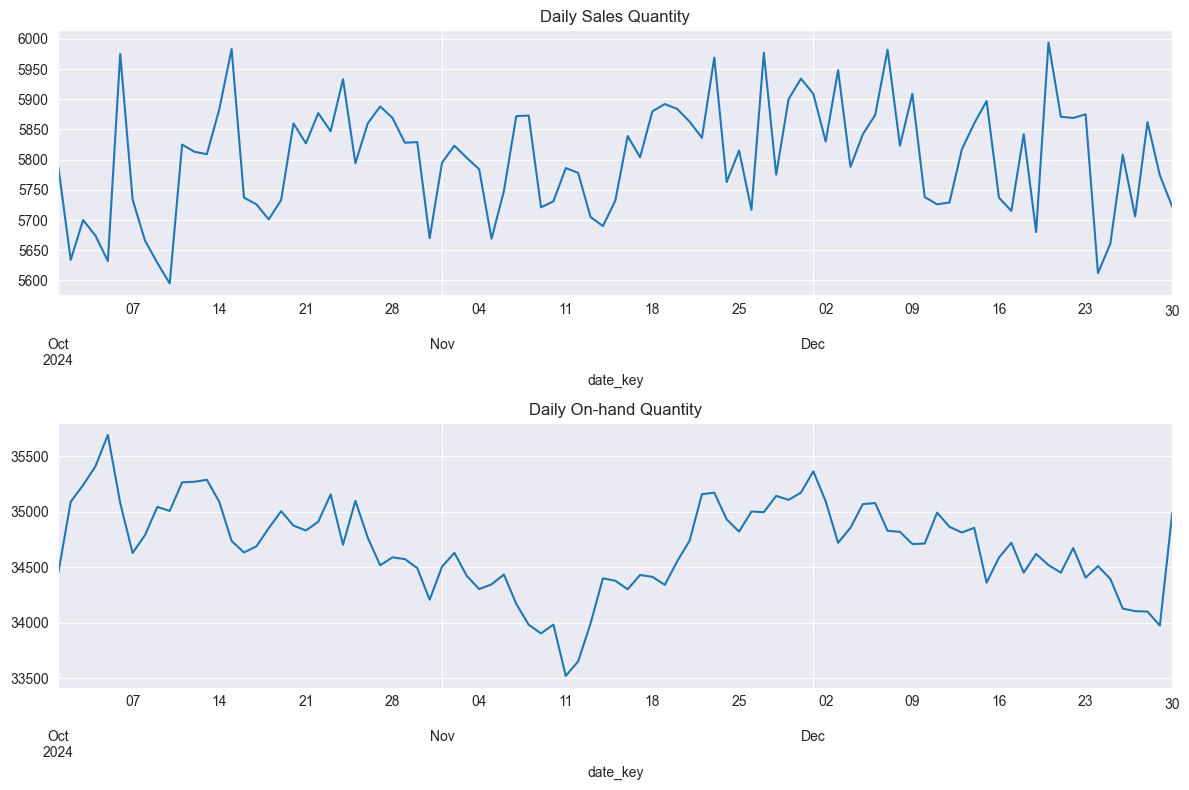

In [10]:
from snowflake.snowpark.functions import col, sum as s_sum

# 1) Ensure types on the Snowpark DF
df_typed = (
    df.with_column("DATE_KEY", col("DATE_KEY").cast("date"))
      .with_column("SALES_QUANTITY",   col("SALES_QUANTITY").cast("double"))
      .with_column("ON_HAND_QUANTITY", col("ON_HAND_QUANTITY").cast("double"))
)

# 2) Daily aggregates (Snowpark)
daily_df = (
    df_typed.group_by("DATE_KEY")
            .agg(
                s_sum(col("SALES_QUANTITY")).alias("DAILY_SALES"),
                s_sum(col("ON_HAND_QUANTITY")).alias("DAILY_ON_HAND"),
            )
            .sort(col("DATE_KEY"))
)

# (optional) keep Snowpark DFs similar to your original variables
daily_sales     = daily_df.select("DATE_KEY", "DAILY_SALES")
daily_on_hand   = daily_df.select("DATE_KEY", "DAILY_ON_HAND")

# 3) Convert to pandas for plotting
pdf = daily_df.to_pandas().set_index("DATE_KEY")

# 4) Plot (matplotlib)
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 1, figsize=(12, 8))
pdf["DAILY_SALES"].plot(ax=axes[0], title="Daily Sales Quantity")
pdf["DAILY_ON_HAND"].plot(ax=axes[1], title="Daily On-hand Quantity")
axes[0].set_xlabel("")
axes[1].set_xlabel("Date")
axes[0].set_ylabel("Qty")
axes[1].set_ylabel("Qty")
plt.tight_layout()
plt.show()


## Caclulate expected velocity

Expected velocity is the average sales velocity of a product across all stores in the same cluster, excluding the store in question. This metric helps identify stores that are underperforming compared to other stores in the same cluster.

In [11]:
from snowflake.snowpark.functions import col, lit, sum as s_sum, iff, coalesce
from snowflake.snowpark.window import Window

# 1) Ensure types on base df
df1 = (
    df.with_column("DATE_KEY",         col("DATE_KEY").cast("date"))
      .with_column("SALES_QUANTITY",   col("SALES_QUANTITY").cast("double"))
      .with_column("ON_HAND_QUANTITY", col("ON_HAND_QUANTITY").cast("double"))
)

# 2) Product–store pairs with total sales > 10
ever_sold_stores = (
    df1.group_by("PRODUCT_ID", "STORE_ID")
       .agg(s_sum(col("SALES_QUANTITY")).alias("TOTAL_SALES"))
       .filter(col("TOTAL_SALES") > lit(10))
       .select("PRODUCT_ID", "STORE_ID")
)

# 3) Keep only those pairs
df2 = df1.join(ever_sold_stores, ["PRODUCT_ID", "STORE_ID"], "inner")

# 4) Bring in cluster info (you already have dim_store_clusters with STORE_ID, CLUSTER)
df3 = df2.join(dim_store_clusters, ["STORE_ID"], "left")

# 5) velocity = SALES_QUANTITY if ON_HAND > 0 else NULL
df3 = df3.with_column(
    "VELOCITY",
    iff(col("ON_HAND_QUANTITY") <= lit(0), lit(None).cast("double"), col("SALES_QUANTITY"))
)

# 6) Compute expected velocity per (date, product, cluster) via window functions
w = Window.partition_by("DATE_KEY", "PRODUCT_ID", "CLUSTER")

df4 = (
    df3
      .with_column("CNT_NONNULL_VEL", s_sum(iff(col("VELOCITY").is_not_null(), lit(1), lit(0))).over(w))
      .with_column("SUM_VEL",         s_sum(col("VELOCITY")).over(w))
)

df5 = (
    df4.with_column(
            "EXPECTED_VELOCITY",
            iff(
                col("CNT_NONNULL_VEL") > lit(1),
                (col("SUM_VEL") - coalesce(col("VELOCITY"), lit(0.0))) / (col("CNT_NONNULL_VEL") - lit(1)),
                lit(None).cast("double")
            )
        )
        .with_column("EXPECTED_VELOCITY", coalesce(col("EXPECTED_VELOCITY"), lit(0.0)))  # fillna(0.0)
        .drop("CNT_NONNULL_VEL", "SUM_VEL")
)

# 7) Final selection
prepared_df = df5.select(
    "DATE_KEY",
    "PRODUCT_ID",
    "STORE_ID",
    "SALES_QUANTITY",
    "ON_HAND_QUANTITY",
    "EXPECTED_VELOCITY",
)

prepared_df  # optional


,date_key,product_id,store_id,sales_quantity,on_hand_quantity,expected_velocity
0,2024-10-05,101,98979065024344198,0.0,0.0,0.000000
1,2024-10-07,101,385376782331704852,0.0,0.0,0.000000
2,2024-10-11,101,686677604694809978,0.0,0.0,0.000000
3,2024-10-13,101,870053854117237080,0.0,0.0,0.000000
4,2024-10-15,101,11032598542241361,0.0,0.0,0.000000
...,...,...,...,...,...,...
530980,2024-10-10,180,288226339723528194,3.0,6.0,1.900000
530981,2024-10-19,180,216725622896583296,3.0,19.0,1.875000
530982,2024-11-02,180,464331424209448676,3.0,3.0,1.900000
530983,2024-12-25,180,972883243019783470,3.0,7.0,1.933333


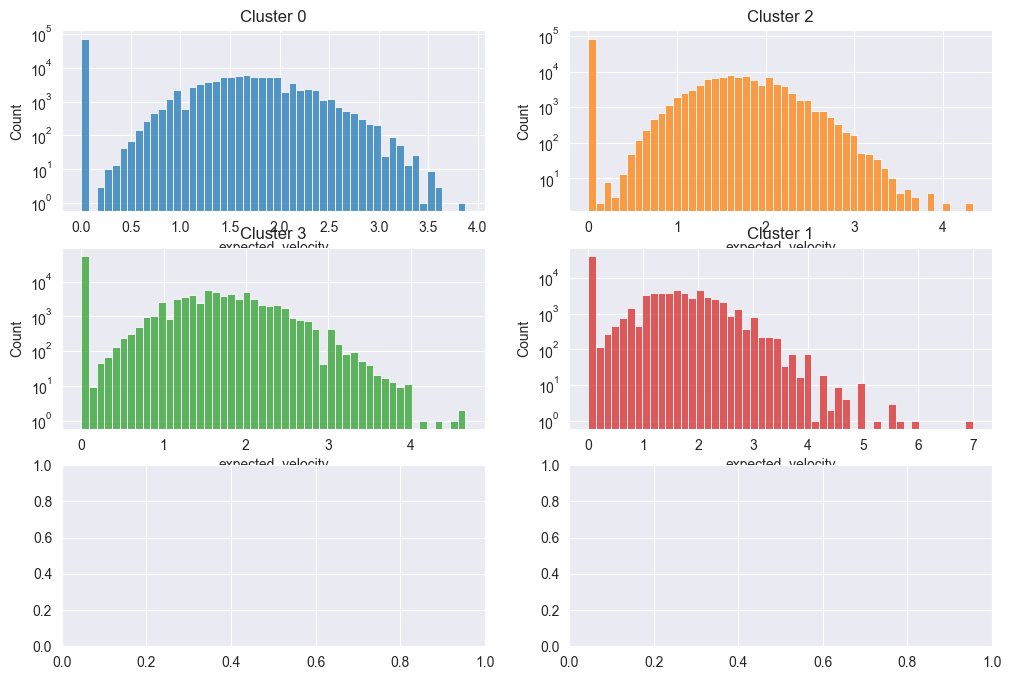

In [12]:
# Histogram of EXPECTED_VELOCITY per CLUSTER (Snowpark → pandas → Matplotlib)

import math
import numpy as np
import matplotlib.pyplot as plt
from snowflake.snowpark.functions import col

# Pull just what we need to the client for plotting
pdf = (
    df5.select("CLUSTER", "EXPECTED_VELOCITY")
       .to_pandas()
)

# Drop NaNs (they’d be skipped in pandas anyway, but be explicit)
pdf = pdf.dropna(subset=["EXPECTED_VELOCITY"])

# Unique clusters (sorted for stable layout)
clusters = sorted(pdf["CLUSTER"].unique().tolist())
n = len(clusters)

if n == 0:
    print("No clusters to plot.")
else:
    # Make a compact grid: 2 columns, rows = ceil(n/2)
    cols = 2 if n > 1 else 1
    rows = math.ceil(n / cols)

    fig, axes = plt.subplots(rows, cols, figsize=(12, 4 * rows), squeeze=False)

    for i, cluster in enumerate(clusters):
        ax = axes[i // cols, i % cols]
        vals = pdf.loc[pdf["CLUSTER"] == cluster, "EXPECTED_VELOCITY"].values

        ax.hist(vals, bins=50)
        ax.set_title(f"Cluster {cluster}")
        ax.set_yscale("log")
        ax.set_xlabel("Expected Velocity")
        ax.set_ylabel("Count")

    # Hide any unused axes (when n is odd)
    for j in range(n, rows * cols):
        fig.delaxes(axes[j // cols, j % cols])

    plt.tight_layout()
    plt.show()


## Let's analyze the data
We will find periods of inactivity and identify the lowest positive stock level maintained during these no-sale streaks, known as the resistance line, which can help you determine what is driving inactivity. For example, if certain products repeatedly fail to sell at a specific stock level, it could signal demand saturation, marketing challenges, or inventory management issues.

In [ ]:
from snowflake.snowpark.functions import (
    col, lit, sum as s_sum, min as s_min, exp, iff, coalesce, call_function
)
from snowflake.snowpark.window import Window

# Windows
w_all  = Window.partition_by("PRODUCT_ID", "STORE_ID")
w_desc = Window.partition_by("PRODUCT_ID", "STORE_ID").order_by(col("DATE_KEY").desc())
w_asc  = Window.partition_by("PRODUCT_ID", "STORE_ID").order_by(col("DATE_KEY").asc())

# 0) Ensure types (defensive casts)
base = (
    prepared_df
      .with_column("DATE_KEY",         col("DATE_KEY").cast("date"))
      .with_column("SALES_QUANTITY",   col("SALES_QUANTITY").cast("double"))
      .with_column("ON_HAND_QUANTITY", col("ON_HAND_QUANTITY").cast("double"))
      .with_column("EXPECTED_VELOCITY",col("EXPECTED_VELOCITY").cast("double"))
)

# ---- Inactivity streak from the most-recent day backward ----
# Flag rows with (sales=0 & on_hand>0)
g1 = base.with_column(
        "F_INACT",
        iff((col("SALES_QUANTITY") == lit(0)) & (col("ON_HAND_QUANTITY") > lit(0)), lit(1), lit(0))
     )

# Running count of zeros when scanning from latest → older (prefix of non-inactivity breaker)
g1 = g1.with_column(
        "PREFIX_ZERO",
        s_sum(iff(col("F_INACT") == lit(0), lit(1), lit(0))).over(w_desc)
     )

# Keep the leading streak (only rows until the first breaker)
g1 = g1.with_column(
        "VALID_STREAK",
        iff(col("PREFIX_ZERO") == lit(0), col("F_INACT"), lit(0))
     )

# Count days in the streak & sum expected velocity over the streak
g1 = (
    g1.with_column("CURRENT_INACTIVITY", s_sum(col("VALID_STREAK")).over(w_all))
      .with_column("STREAK_EV", s_sum(iff(col("VALID_STREAK") == lit(1),
                                          col("EXPECTED_VELOCITY"), lit(0.0))).over(w_all))
      .with_column("PROB_INACTIVITY_POISSON", exp(-col("STREAK_EV")))  # exp(-sum λ)
)

# ---- Resistance line & related stats ----
# Resistance line = min on_hand over the group
g1 = g1.with_column("RESISTANCE_LINE", s_min(col("ON_HAND_QUANTITY")).over(w_all))

# Hits: count transitions (no-sales) from > RL to == RL; first == RL also counts
g1 = (
    g1.with_column("EQUALS_RL", iff((col("SALES_QUANTITY") <= lit(0)) &
                                    (col("ON_HAND_QUANTITY") == col("RESISTANCE_LINE")), lit(1), lit(0)))
      .with_column("ABOVE_RL",  iff((col("SALES_QUANTITY") <= lit(0)) &
                                    (col("ON_HAND_QUANTITY") >  col("RESISTANCE_LINE")), lit(1), lit(0)))
      .with_column("LAG_ABOVE_RL", call_function("LAG", col("ABOVE_RL"), lit(1)).over(w_asc))
      .with_column("PREV_ABOVE_OR_START", coalesce(col("LAG_ABOVE_RL"), lit(1)))
      .with_column("HIT_FLAG", iff((col("EQUALS_RL") == lit(1)) & (col("PREV_ABOVE_OR_START") == lit(1)),
                                   lit(1), lit(0)))
      .with_column("RESISTANCE_LINE_HITS", s_sum(col("HIT_FLAG")).over(w_all))
)

# Expected velocity when at the resistance line (sum over days where on_hand == RL)
g1 = (
    g1.with_column("RL_EV_SUM", s_sum(iff(col("ON_HAND_QUANTITY") == col("RESISTANCE_LINE"),
                                          col("EXPECTED_VELOCITY"), lit(0.0))).over(w_all))
      .with_column("RL_CNT",    s_sum(iff(col("ON_HAND_QUANTITY") == col("RESISTANCE_LINE"),
                                          lit(1), lit(0))).over(w_all))
      .with_column("RESISTANCE_LINE_EXPECTED_SALES_PROBABILITY",
                   iff(col("RL_CNT") > lit(0), exp(-col("RL_EV_SUM")), lit(None).cast("double")))
)

# Last on-hand (most-recent day) and total sales days
g1 = (
    g1.with_column("LAST_ON_HAND_QUANTITY",
                   call_function("FIRST_VALUE", col("ON_HAND_QUANTITY")).over(w_desc))
      .with_column("TOTAL_SALES_DAYS",
                   s_sum(iff(col("SALES_QUANTITY") > lit(0), lit(1), lit(0))).over(w_all))
)

# ---- Final reduction to one row per (product_id, store_id) ----
result = g1.select(
    "PRODUCT_ID",
    "STORE_ID",
    col("CURRENT_INACTIVITY").alias("current_inactivity"),
    col("LAST_ON_HAND_QUANTITY").alias("last_on_hand_quantity"),
    col("TOTAL_SALES_DAYS").alias("total_sales_days"),
    col("STREAK_EV").alias("expected_velocity"),
    col("PROB_INACTIVITY_POISSON").alias("probability_inactivity_poisson"),
    col("RESISTANCE_LINE").alias("resistance_line"),
    col("RESISTANCE_LINE_HITS").alias("resistance_line_hits"),
    col("RL_EV_SUM").alias("resistance_line_expected_velocity"),
    col("RESISTANCE_LINE_EXPECTED_SALES_PROBABILITY").alias("resistance_line_expected_sales_probability"),
).distinct()



result

In [14]:
from snowflake.snowpark.functions import col, lit, call_function
import re

# Pick numeric columns from the Snowpark schema
numeric_kws = ("DECIMAL", "DOUBLE", "FLOAT", "NUMBER", "INT")
numeric_cols = [
    f.name
    for f in result.schema.fields
    if any(k in str(f.datatype).upper() for k in numeric_kws)
]

def describe_numeric(df, colname):
    c = col(colname)
    return df.select(
        lit(colname).alias("column"),
        call_function("COUNT", c).cast("double").alias("count"),
        call_function("AVG", c).alias("mean"),
        call_function("STDDEV_SAMP", c).alias("std"),
        call_function("MIN", c).alias("min"),
        # percentiles via WITHIN GROUP
        call_function("PERCENTILE_CONT", lit(0.25)).within_group(c).alias("25%"),
        call_function("PERCENTILE_CONT", lit(0.50)).within_group(c).alias("50%"),
        call_function("PERCENTILE_CONT", lit(0.75)).within_group(c).alias("75%"),
        call_function("MAX", c).alias("max"),
    )

# Build the summary for all numeric columns and union them
if not numeric_cols:
    print("No numeric columns found in `result`.")
else:
    desc_df = None
    for colname in numeric_cols:
        part = describe_numeric(result, colname)
        desc_df = part if desc_df is None else desc_df.union_all(part)

    # Peek
    desc_df.show()        # or: desc_pdf = desc_df.to_pandas(); desc_pdf


,product_id,store_id,current_inactivity,last_on_hand_quantity,total_sales_days,expected_velocity,probability_inactivity_poisson,resistance_line,resistance_line_hits,resistance_line_expected_velocity,resistance_line_expected_sales_probability
count,5835.0,5835.0,5835.000000,5835.000000,5835.000000,5835.000000,5835.000000,5835.000000,5835.000000,5835.000000,13.000000
mean,140.490146,503286171749716416.0,0.143445,5.993488,41.149786,0.243320,0.898219,0.016624,0.000171,0.004588,0.164389
std,23.090342,300386892304597632.0,0.408375,8.507632,12.672945,0.715739,0.272841,0.473390,0.013091,0.106623,0.088380
min,101.0,8802679258011985.0,0.000000,0.000000,5.000000,0.000000,0.000569,0.000000,0.000000,0.000000,0.006914
25%,120.5,236797218327345888.0,0.000000,0.000000,32.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.114559
50%,140.0,503445876466767232.0,0.000000,2.000000,41.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.135335
75%,160.0,787426117215596416.0,0.000000,10.000000,50.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.223130
max,180.0,974851238042301440.0,4.000000,79.000000,85.000000,7.472222,1.000000,21.000000,1.000000,4.974206,0.315421


### Define your alerting conditions below
We will define the alert conditions that will flag potential issues such as "Phantom Inventory" or "Zero Sales" based on specific thresholds of inactivity or other criteria, so you can identify and address issues proactively.

In [15]:
from snowflake.snowpark.functions import col, lit, iff

# Start from result; add ALERT with the two-tier rule (second rule overrides the first)
alerts = (
    result
    # Rule 1 → Phantom Inventory
    .with_column(
        "ALERT",
        iff(
            (col("RESISTANCE_LINE_HITS") >= lit(2)) &
            (col("RESISTANCE_LINE") >= lit(1)) &
            (col("RESISTANCE_LINE_EXPECTED_SALES_PROBABILITY") < lit(0.1)),
            lit("Phantom Inventory"),
            lit("No Alert"),
        )
    )
    # Rule 2 → Zero Sales (overrides if condition is met)
    .with_column(
        "ALERT",
        iff(
            (col("CURRENT_INACTIVITY") >= lit(3)) &
            (col("PROBABILITY_INACTIVITY_POISSON") < lit(0.1)) &
            (col("LAST_ON_HAND_QUANTITY") > lit(0)),
            lit("Zero Sales"),
            col("ALERT"),
        )
    )
)

# Keep only rows that actually triggered an alert
alerts = alerts.filter(col("ALERT") != lit("No Alert"))

# value_counts("alert")
alert_counts = alerts.group_by("ALERT").count().sort(col("COUNT").desc())

# Optional peeks:
alert_counts.show()
alerts.show()


,product_id,store_id,current_inactivity,last_on_hand_quantity,total_sales_days,expected_velocity,probability_inactivity_poisson,resistance_line,resistance_line_hits,resistance_line_expected_velocity,resistance_line_expected_sales_probability,alert
220,104,11032598542241361,4.0,18.0,37.0,6.422078,0.001625,0.0,0.0,0.0,NaN,Zero Sales
892,113,209477354286544859,3.0,29.0,43.0,4.159707,0.015612,0.0,0.0,0.0,NaN,Zero Sales
1076,115,787426117215596430,3.0,12.0,51.0,5.700000,0.003346,0.0,0.0,0.0,NaN,Zero Sales
1631,123,363656734287973762,3.0,33.0,49.0,4.923077,0.007277,0.0,0.0,0.0,NaN,Zero Sales
3023,142,464331424209448676,3.0,2.0,49.0,4.416667,0.012074,0.0,0.0,0.0,NaN,Zero Sales
3116,143,690794113278183045,3.0,12.0,35.0,5.085470,0.006186,0.0,0.0,0.0,NaN,Zero Sales
3860,153,923974522106577221,4.0,5.0,45.0,7.472222,0.000569,0.0,0.0,0.0,NaN,Zero Sales
4490,162,571177652493709771,3.0,9.0,29.0,4.474747,0.011393,0.0,0.0,0.0,NaN,Zero Sales
4531,163,95933801595507685,3.0,14.0,29.0,6.533333,0.001454,0.0,0.0,0.0,NaN,Zero Sales
4778,166,503445876466767261,4.0,13.0,33.0,7.211111,0.000738,0.0,0.0,0.0,NaN,Zero Sales


## Prepare labels for the alert
We will prepare labels for the alerts to enrich them with additional information to help you quickly understand the nature of the issue and which product/store combinations are affected. 

In [16]:
# products_df = SELECT product_id, product FROM HARMONIZED_RETAILER_DIM_PRODUCT
products_df = (
    session.table("HARMONIZED_RETAILER_DIM_PRODUCT")
           .select("PRODUCT_ID", "PRODUCT")
)

# Optional peek
# products_df.show()


In [17]:
from snowflake.snowpark.functions import col, lit, concat

stores_df = (
    session.table("HARMONIZED_RETAILER_DIM_STORE")
           .select(
               col("STORE_ID"),
               concat(col("RETAILER"), lit("_"), col("STORE_ID").cast("string")).alias("STORE"),
           )
)

# Optional peek
# stores_df.show()


In [18]:
# --- Build merged_alerts in Snowpark (LEFT joins) ---
from snowflake.snowpark.functions import col

merged_alerts_sp = (
    alerts
      .join(products_df.select("PRODUCT_ID","PRODUCT"), ["PRODUCT_ID"], "left")
      .join(stores_df.select("STORE_ID","STORE"), ["STORE_ID"], "left")
      .select(
          "PRODUCT_ID","STORE_ID","ALERT",
          "CURRENT_INACTIVITY","RESISTANCE_LINE","RESISTANCE_LINE_HITS",
          "PRODUCT","STORE"
      )
)

# Pull just what we need for the widget into pandas
import pandas as pd
merged_alerts = merged_alerts_sp.to_pandas()

# --- Build dropdown options ---
options = []
for _, row in merged_alerts.iterrows():
    label = f"{row['PRODUCT']} | {row['STORE']} | {row['ALERT']}"
    value = (
        int(row["PRODUCT_ID"]),
        int(row["STORE_ID"]),
        row["ALERT"],
        f"{int(row['CURRENT_INACTIVITY'])} | {row['RESISTANCE_LINE']} | {int(row['RESISTANCE_LINE_HITS'])}",
    )
    options.append((label, value))

# If no alerts, short-circuit
if not options:
    print("No alerts to display.")
else:
    import matplotlib.pyplot as plt
    import ipywidgets as widgets
    from IPython.display import display

    product_store_alert_dropdown = widgets.Dropdown(
        options=options,
        description="Selection:",
        layout=widgets.Layout(width="95%"),
    )

    def update_plot(selection_tuple):
        product_id, store_id, alert, info = selection_tuple

        # Filter in Snowpark, then convert to pandas for resampling/fill + plotting
        sel_sp = (
            df.filter((col("PRODUCT_ID") == product_id) & (col("STORE_ID") == store_id))
              .select("DATE_KEY","SALES_QUANTITY","ON_HAND_QUANTITY")
        )
        sel = sel_sp.to_pandas()

        if sel.empty:
            print("No data available for the selected product-store combination.")
            return

        # Ensure datetime index and daily frequency
        sel["DATE_KEY"] = pd.to_datetime(sel["DATE_KEY"])
        sel = sel.sort_values("DATE_KEY").set_index("DATE_KEY")

        # Reindex to daily range
        idx = pd.date_range(sel.index.min(), sel.index.max(), freq="D")
        sel = sel.reindex(idx)

        # Forward-fill on-hand; zero-fill sales
        sel["ON_HAND_QUANTITY"] = sel["ON_HAND_QUANTITY"].ffill()
        sel["SALES_QUANTITY"]   = sel["SALES_QUANTITY"].fillna(0)

        # Plot
        plt.figure(figsize=(12, 6))
        plt.plot(sel.index, sel["SALES_QUANTITY"], label="Sales Quantity")
        plt.plot(sel.index, sel["ON_HAND_QUANTITY"], label="On-hand Quantity")
        plt.title(
            f"Sales and On-hand Quantity\nProduct {product_id}, Store {store_id}, Alert: {alert}, INFO: {info}"
        )
        plt.xlabel("Date")
        plt.ylabel("Quantity")
        plt.legend()
        plt.show()

    interactive_plot = widgets.interactive(
        update_plot, selection_tuple=product_store_alert_dropdown
    )
    display(interactive_plot)

    # Optional: auto-render the first selection immediately
    update_plot(options[0][1])


interactive(children=(Dropdown(description='Selection:', options=(('LunaTech Helios | target_11032598542241361…